In [9]:
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np

In [122]:
current_dir = os.getcwd()

In [123]:
# loading the data required for detecting the license plates using cascade classifier.
plate_cascade_path = os.path.join(current_dir, '../models/haarcascade_ua_license_plate.xml')
plate_cascade = cv2.CascadeClassifier(plate_cascade_path)

In [124]:
def detect_plate(img, text = ''): # the function detects and performs blurring on the number plate.
    plate_img = img.copy() # first copy of the image
    reg_of_intr = img.copy() # second copy of the image
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.4, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        plate = reg_of_intr[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)

    return plate_img, plate

In [125]:
def display(img_, title='', fontsize=30):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

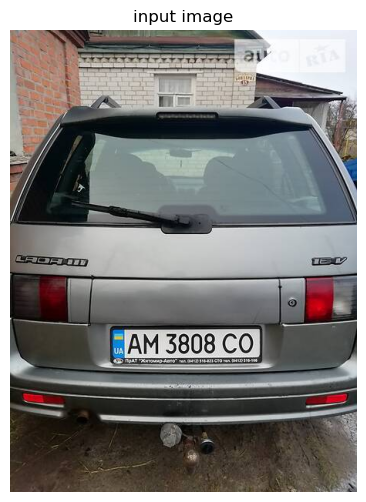

In [126]:
image_path = os.path.join(current_dir, '../images/AM3808CO.jpg')
img = cv2.imread(image_path)
display(img, 'input image')

In [127]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)

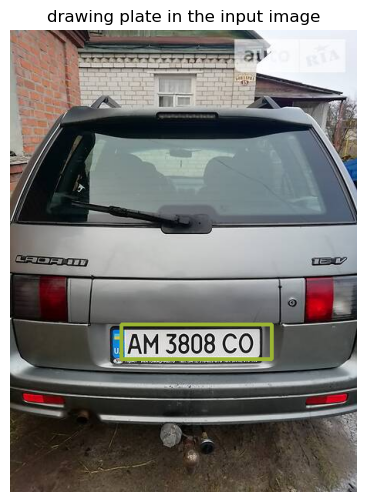

In [128]:
display(output_img, 'drawing plate in the input image')

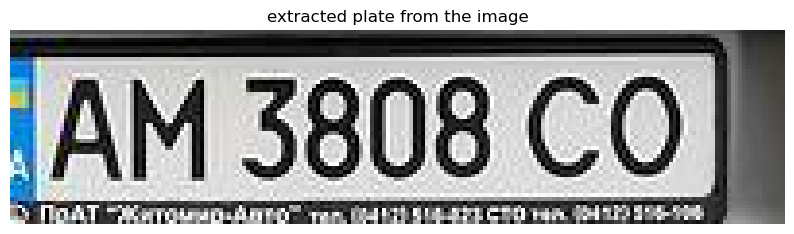

In [129]:
display(plate, 'extracted plate from the image')

In [130]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('../images/contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (76, 202, 102), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
            #print(img_res)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [131]:
def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75)) # Resize the image to a fixed size
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Apply binary thresholding
    img_binary_lp = cv2.erode(img_binary_lp, (3,3)) # Apply erosion to remove noise
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3)) # Apply dilation to restore original size

    LP_WIDTH = img_binary_lp.shape[0] # Get the width of the license plate
    LP_HEIGHT = img_binary_lp.shape[1] # Get the height of the license plate

    # Make borders white
    img_binary_lp[0:3,:] = 255 # Minimum character height
    img_binary_lp[:,0:3] = 255 # Maximum character height
    img_binary_lp[72:75,:] = 255 # Minimum character width
    img_binary_lp[:,330:333] = 255 # Maximum character width

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray') # Display the binary image
    plt.show()
    cv2.imwrite('../images/contour.jpg',img_binary_lp) # Save the binary image to a file

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp) # Find character contours

    return char_list # Return the list of character contours

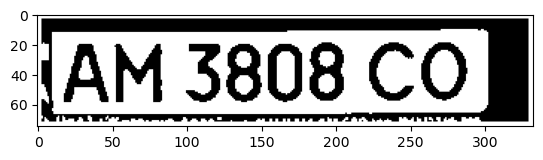

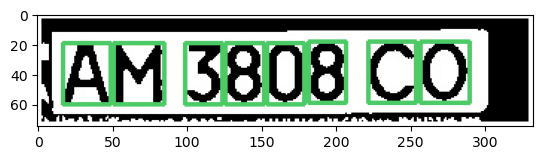

In [132]:
char = segment_characters(plate)

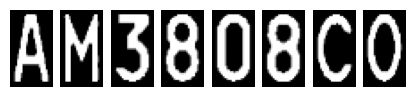

In [133]:
num_chars_to_display = min(10, len(char))

for i in range(num_chars_to_display):
    plt.subplot(1, 10, i+1)
    if i < len(char):
        plt.imshow(char[i], cmap='gray')
    plt.axis('off')

## Model Keras for character recognition

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

2024-06-14 22:47:17.873742: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 22:47:17.879458: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 22:47:17.955922: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 22:47:19.430818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [135]:
train_data_path = os.path.join(current_dir, '../data/train')
val_data_path = os.path.join(current_dir, '../data/val')

# Create ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.05, height_shift_range=0.05)
train_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=(28,28),
        batch_size=32,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        val_data_path,
        target_size=(28,28),
        batch_size=32,
        class_mode='categorical')

# Define stop training callback
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc > 0.992:
            self.model.stop_training = True

# Define TensorBoard callback
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [136]:
# Create model
model_keras = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), input_shape=(28, 28, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(units=36, activation='softmax') # Change units to match the number of classes in your dataset
])

# Compile model
model_keras.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model
batch_size = 32
callbacks = [tensorboard_callback, stop_training_callback()]
history_keras = model_keras.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // batch_size,
          epochs=100,
          callbacks=callbacks)

Epoch 1/100
27/27 [==============================] - 3s 68ms/step - loss: 3.5840 - accuracy: 0.0324 - val_loss: 3.5608 - val_accuracy: 0.0573
Epoch 2/100
27/27 [==============================] - 1s 51ms/step - loss: 3.5530 - accuracy: 0.0509 - val_loss: 3.5320 - val_accuracy: 0.0625
Epoch 3/100
27/27 [==============================] - 1s 55ms/step - loss: 3.5182 - accuracy: 0.0671 - val_loss: 3.4896 - val_accuracy: 0.0885
Epoch 4/100
27/27 [==============================] - 2s 57ms/step - loss: 3.4707 - accuracy: 0.1053 - val_loss: 3.4277 - val_accuracy: 0.1042
Epoch 5/100
27/27 [==============================] - 1s 53ms/step - loss: 3.3934 - accuracy: 0.1204 - val_loss: 3.3108 - val_accuracy: 0.1719
Epoch 6/100
27/27 [==============================] - 2s 57ms/step - loss: 3.2566 - accuracy: 0.1377 - val_loss: 3.1215 - val_accuracy: 0.2031
Epoch 7/100
27/27 [==============================] - 1s 51ms/step - loss: 3.0277 - accuracy: 0.2257 - val_loss: 2.8302 - val_accuracy: 0.4271
Epoch 

In [137]:
model_keras.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 3, 3, 64)        

In [138]:
# Evaluate the model on test data
test_loss, test_accuracy = model_keras.evaluate(validation_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

7/7 [==============================] - 0s 34ms/step - loss: 0.0354 - accuracy: 0.9907
Test Loss: 0.03535370156168938
Test Accuracy: 0.9907407164573669


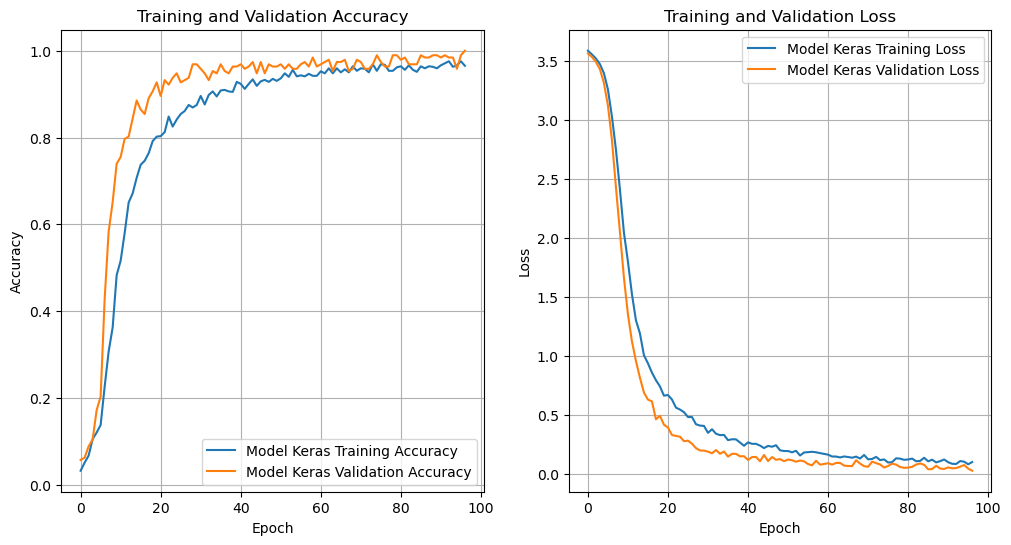

In [139]:
# Visualization of the training schedule
def plot_training_histories(histories, names):
    plt.figure(figsize=(12, 6))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['accuracy'], label=name + ' Training Accuracy')
        plt.plot(history.history['val_accuracy'], label=name + ' Validation Accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plotting loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['loss'], label=name + ' Training Loss')
        plt.plot(history.history['val_loss'], label=name + ' Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Call the function to plot the graph
plot_training_histories([history_keras], ['Model Keras'])

In [140]:
# Predicting the output
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char): # iterate over the symbols
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3) # image preparation for the model
        y_proba = model_keras.predict(img, verbose=0)[0] # get probabilities for each class
        y_ = np.argmax(y_proba) # choose the class with the highest probability
        character = dic[y_] # get a symbol corresponding to the predicted class
        output.append(character) # save the result in the list

    plate_number = ''.join(output) # combine all symbols into a line

    return plate_number

print(show_results(char))

AM3808CO


In [4]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    predicted_char = show_results(char)[i]  # prediction before derivation
    plt.title(f'predicted: {predicted_char}') # passing char as an argument
    plt.axis('off')
plt.show()

NameError: name 'plt' is not defined

In [142]:
def display_result(img_, title='', recognized_text='', font_scale=1, font_thickness=2):
    # Copy the image to avoid modifying the original one
    img = img_.copy()

    # Font settings for OpenCV
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_position = (100, 50)  # Starting position for the text

    # Add recognized text to the image
    cv2.putText(img, recognized_text, text_position, font, font_scale, (0, 255, 0), font_thickness, cv2.LINE_AA)

    # Convert the image from BGR to RGB for displaying with matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with the title
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

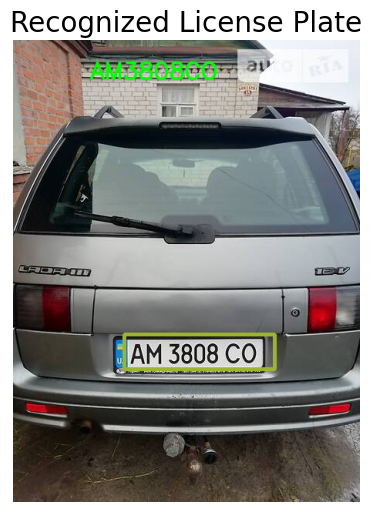

In [143]:
plate_number = show_results(char)
display_result(output_img, title='Recognized License Plate', recognized_text=plate_number)

In [144]:
# Save the model in the format native Keras
model_keras.save("model_character_recognition.keras")